In [39]:
import pandas as pd
import numpy as np
import os
import pickle
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from data_loader import get_identifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def read_validation_additional_lines_labels(file_path='additional_lines_labels.csv'):
    df = pd.read_csv(file_path, index_col=0, dtype='str')
    df.index = [tuple(n.split('_')) for n in df.index]
    mapping = {'0': 0.,
               '0*': 0.,
               '0(0.5)': 0.2,
               '0(1)': 0.4,
               '0/1': 0.4,
               '0(1.5)': 0.6,
               '0(1.5/2)': 0.8,
               '0(2)': 0.8,
               '0(2)*': 0.8,
               '1': 1.,
               '1*': 1.,
               'nan': np.nan,
               '-': np.nan}
    for col in df:
        values = [mapping[v] if v == v else np.nan for v in df[col]]
        df[col] = values
    return df


def generate_label_for_3R(name_file, classify_label_file):
    names = pickle.load(open(name_file, 'rb'))
    labels = pickle.load(open(classify_label_file, 'rb'))
    assert len(set([get_identifier(names[i])[:2] for i in names])) == 1
    wells = [get_identifier(names[i])[-2:] for i in names]
    label_dict = {}
    for w in set(wells):
        inds = [i for i in names if get_identifier(names[i])[-2:] == w]
        inds = sorted(inds, key=lambda x: -int(get_identifier(names[x])[2]))
        well_label = [labels[i] for i in inds if labels[i][1] > 0]
        if len(well_label) == 0:
            continue
        l = well_label[0][0]
        if isinstance(l, np.ndarray) and l.size == 4:
            l = (l[1] + l[2] * 2 + l[3] * 3)/3
        label_dict[w] = l
    return label_dict


def evaluate_confmat(y_trues, y_preds, soft=True):
    conf_mat = np.zeros((6, 4))
    for y_true, y_pred in zip(y_trues, y_preds):
        label = int(np.round(y_true * 5))
        if soft:
            conf_mat[label] += y_pred.reshape((4,))
        else:
            conf_mat[label, np.argmax(y_pred)] += 1
    conf_mat = conf_mat / conf_mat.sum(1, keepdims=True)
    return conf_mat
    

def evaluate_binary_metric(y_trues, y_preds, cutoff=1):
    _y_preds = y_preds[:, cutoff:].sum(1)
    _y_trues = y_trues
    
    pos_rate = sum(_y_trues) / len(_y_trues)
    
    s1 = precision_score(_y_trues, _y_preds > 0.5)
    s2 = recall_score(_y_trues, _y_preds > 0.5)
    s3 = f1_score(_y_trues, _y_preds > 0.5)
    s4 = roc_auc_score(_y_trues, _y_preds)
    
    
    s5 = []
    for _ in range(100):
        inds = np.random.choice(np.arange(len(_y_trues)), (len(_y_trues),), replace=True)
        s5.append(roc_auc_score(_y_trues[inds], _y_preds[inds]))
    s5 = (np.mean(s5), np.std(s5))
    
    
    print("N-samples: %d\tPos rate: %.3f\tPrec: %.3f\tRecall: %.3f\tF1: %.3f\tAUC: %.3f" % \
          (len(_y_trues), pos_rate, s1, s2, s3, s4))
    return s1, s2, s3, s4, s5


def plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=1.5, linewidth=0.2, capsize=2.0):
    for line, curve in roc_auc_curves.items():
        x = sorted(curve.keys())
        y = [curve[_x][3] for _x in x]
        yerr = [curve[_x][4][1] for _x in x] if len(curve[x[0]] ) >4 else None
        plt.errorbar(x, 
                     y, 
                     yerr=yerr, 
                     fmt='-', 
                     label=line, 
                     marker=marker_mapping[line] if line in marker_mapping else 'o',
                     color=color_mapping[line],
                     markersize=markersize, 
                     linewidth=linewidth, 
                     capsize=capsize)
    
    if plot_median:
        x = sorted(set().union(*[curve.keys() for curve in roc_auc_curves.values()]))
        median_line = [np.nanmedian([curve[_x][3] if _x in curve else np.nan for curve in roc_auc_curves.values()]) for _x in x]
        plt.plot(x, median_line, '*-', color='k', label='Median', markersize=2*markersize, linewidth=2*linewidth)

    plt.legend(ncol=2)
    plt.ylim(0.4, 1.01)
    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("ROC-AUC")


def plot_roc_auc_box(roc_auc_curves, start=4, end=10):
    scores_by_day = []
    for line, curve in roc_auc_curves.items():
        x = sorted(curve.keys())
        for _x in x:
            scores_by_day.append((_x, curve[_x][3]))
    
    scores_by_day = pd.DataFrame(np.array(scores_by_day), columns=['day', 'score'])
    sns.boxplot(x='day',
                y='score',
                data=scores_by_day,
                color=(0.9, 0.9, 0.9, 1.0))
    plt.ylim(0.4, 1.01)
    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("ROC-AUC")

    
def load_cla_pred_as_dict(path):
    pred_file = os.path.join(path, 'cla.pkl')
    preds = pickle.load(open(pred_file, 'rb'))
    pred_dict = dict(zip([get_identifier(n) for n in preds['pred_names']], preds['cla_preds']))
    return pred_dict


def report_series_accuracy(pred_dicts, 
                           label_dict, 
                           exclude_ambiguous=False, 
                           start=4,
                           end=10,
                           pred_cutoff=2, 
                           label_cutoff=0.5):
    
    label_ks = sorted(label_dict.keys())
    pred_val_df = pd.DataFrame({'label': [label_dict[k] for k in label_ks]})
    pred_val_df.index = label_ks
    
    curve = {}
    for day in np.arange(start, end+1):
        _pred_dicts = [{k[-2:]: v for k, v in pd.items() if int(k[2]) == day} for pd in pred_dicts]
        shared_keys = sorted(set(_pred_dicts[0].keys()) & set(label_dict.keys()))
        shared_keys = [k for k in shared_keys if label_dict[k] == label_dict[k]]
        if exclude_ambiguous:
            shared_keys = [k for k in shared_keys if np.round(label_dict[k]) == label_dict[k]]
        if len(shared_keys) > 10:
            y_trues = np.array([label_dict[k] for k in shared_keys]) > label_cutoff
            y_preds = np.stack([np.stack([pd[k] for k in shared_keys], 0) for pd in _pred_dicts], 0).mean(0)
            curve[int(day)] = evaluate_binary_metric(y_trues, y_preds, cutoff=pred_cutoff)
            pred_val_df['D%d_pred' % day] = [np.mean([pd[k][pred_cutoff:].sum() for pd in _pred_dicts]) \
                                             if k in _pred_dicts[0] else np.nan for k in label_ks]

    return curve, pred_val_df


def combine_multi_line_preds(pred_val_dfs, 
                             label_cutoff=0.5,
                             start=4,
                             end=10,):
    combined_df = []
    all_columns = set().union(*[pred_val_df.columns for pred_val_df in pred_val_dfs.values()])
    for k, pred_val_df in pred_val_dfs.items():
        pred_val_df = deepcopy(pred_val_df)
        pred_val_df.index = [(k, p) for p in pred_val_df.index]
        for c in all_columns:
            if not c in pred_val_df:
                pred_val_df[c] = [np.nan for _ in range(pred_val_df.shape[0])]
        combined_df.append(pred_val_df)

    combined_df = pd.concat(combined_df)
    curve = {}
    for day in np.arange(start, end+1):
        label = np.array(combined_df['label']).flatten()
        pred = np.array(combined_df['D%d_pred' % day]).flatten()
        
        valid_inds = np.where((label == np.round(label)) * (pred == pred))[0]
        res = roc_auc_score(label[valid_inds] > label_cutoff, pred[valid_inds])
        curve[day] = res
    return curve, combined_df


def plot_as_well(pred_val_df, 
                 well='A1', 
                 well_size=14,
                 use_cols=['label', 'D4_pred', 'D5_pred', 'D6_pred', 'D8_pred', 'D10_pred']):
    well_rows = [r for r in pred_val_df.index if r[0] == well]
    sub_df = pred_val_df.loc[well_rows]

    mats = {}
    for col in use_cols:
        mat = -np.ones((well_size, well_size))
        for row, v in zip(sub_df.index, list(sub_df[col])):
            position_code = int(row[1]) - 1
            i, j = position_code // well_size, position_code % well_size
            mat[i, j] = v
        mats[col] = mat
        
    plt.figure(figsize=(3*len(use_cols), 3), frameon=False)
    for i, col in enumerate(use_cols):
        plt.subplot(1, len(use_cols), i+1)
        vmin = -0.1
        vmax = 0.9
        plt.imshow(mats[col], vmin=vmin, vmax=vmax, cmap='viridis')
        plt.axis('off')
    

In [40]:
color_mapping = {
    'Validation: 3R': matplotlib.cm.tab20(0),
    'Test: 3R': matplotlib.cm.tab20(18),
    'Test: TNNI': matplotlib.cm.tab20(2),
    
    '12-well: 3R': matplotlib.cm.tab20(0),
    '12-well: 839': matplotlib.cm.tab20(4),
    '12-well: 975': matplotlib.cm.tab20(4),
    '24-well: 3R': matplotlib.cm.tab20(1),
    '24-well: 839/975': matplotlib.cm.tab20(5),
    
    'Diff. Media: 3R': matplotlib.cm.tab20(0),
    'Diff. Media: 839': matplotlib.cm.tab20(4),
    'Diff. Instrument: 3R': matplotlib.cm.tab20(1),
    
    'Test: 477': matplotlib.cm.tab20(6),
    'Test: 202': matplotlib.cm.tab20(7),
    'Test: 20': matplotlib.cm.tab20(8),
    'Test: 100': matplotlib.cm.tab20(9),
    'Test: 142': matplotlib.cm.tab20(10),
    'Test: 273': matplotlib.cm.tab20(11),
    'Test: 839': matplotlib.cm.tab20(4),
    'Test: 480': matplotlib.cm.tab20(2),
    'Test: 854': matplotlib.cm.tab20(3),
    'Test: 975': matplotlib.cm.tab20(5),
    
    'Test: Combined': (0.9, 0.9, 0.9, 1.0),
    
    'Prospective: 3R': matplotlib.cm.tab20(0),
}

marker_mapping = {
    '12-well: 839': 'v',
    '12-well: 975': '^',
}

<br/><br/><br/><br/>
### Classification perf: original validation/test ###

Validation: 3R
N-samples: 1104	Pos rate: 0.680	Prec: 0.697	Recall: 0.734	F1: 0.715	AUC: 0.600
N-samples: 1104	Pos rate: 0.680	Prec: 0.626	Recall: 0.614	F1: 0.620	AUC: 0.376
N-samples: 1104	Pos rate: 0.680	Prec: 0.914	Recall: 0.482	F1: 0.631	AUC: 0.795
N-samples: 1104	Pos rate: 0.680	Prec: 0.935	Recall: 0.534	F1: 0.680	AUC: 0.826
N-samples: 1104	Pos rate: 0.680	Prec: 0.922	Recall: 0.688	F1: 0.788	AUC: 0.865
N-samples: 1104	Pos rate: 0.680	Prec: 0.897	Recall: 0.779	F1: 0.834	AUC: 0.857
N-samples: 1104	Pos rate: 0.680	Prec: 0.851	Recall: 0.877	F1: 0.864	AUC: 0.885
N-samples: 1104	Pos rate: 0.680	Prec: 0.947	Recall: 0.780	F1: 0.855	AUC: 0.908
N-samples: 1104	Pos rate: 0.680	Prec: 0.983	Recall: 0.758	F1: 0.856	AUC: 0.907
N-samples: 1104	Pos rate: 0.680	Prec: 0.979	Recall: 0.763	F1: 0.858	AUC: 0.912
Test: 3R
N-samples: 478	Pos rate: 0.502	Prec: 0.571	Recall: 0.050	F1: 0.092	AUC: 0.542
N-samples: 478	Pos rate: 0.502	Prec: 0.500	Recall: 0.025	F1: 0.048	AUC: 0.503
N-samples: 478	Pos rate: 0.502

<Figure size 432x288 with 0 Axes>

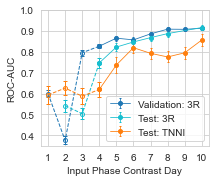

In [41]:
line_paths = {
    'Validation: 3R': 'VALIDATION/line1_3R/ex15_full/',
    'Test: 3R': 'VALIDATION/line1_3R/ex7_full/',
    'Test: TNNI': 'VALIDATION/line3_TNNI/ex4_full/',
}

pred_file_names = [
    'ex-valid-pred-to-15',
]

pred_cutoff = 1
### prepare labels ###
# for line, line_path in line_paths.items():
#     names = pickle.load(open(os.path.join(line_path, '0-to-0', 'names.pkl'), 'rb'))
#     classify_labels = pickle.load(open(os.path.join(line_path, '0-to-0', 'classify_continuous_labels.pkl'), 'rb'))
#     well_labels = {}
#     for k in names:
#         name = names[k]
#         lab = classify_labels[k]
#         well = get_identifier(name)[-2:]
#         day = int(get_identifier(name)[2])
#         if lab[1] > 0 and day >= 13:
#             if not well in well_labels:
#                 well_labels[well] = {}
#             well_labels[well][day] = lab[0][pred_cutoff:].sum()
#     label_dict = {k: np.median(list(well_labels[k].values())) for k in well_labels}
#     with open(os.path.join(line_path, 'cla_labels.pkl'), 'wb') as f:
#         pickle.dump(label_dict, f)
###

roc_auc_curves = {}
pred_val_dfs = {}

for line, line_path in line_paths.items():
    print(line)
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name)) for pred_file_name in pred_file_names]
    label_dict = pickle.load(open(os.path.join(line_path, 'cla_labels.pkl'), 'rb'))
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                label_dict, 
                                                exclude_ambiguous=False, 
                                                pred_cutoff=pred_cutoff,
                                                label_cutoff=0.5,
                                                start=1,
                                                end=10)
    roc_auc_curves[line] = auc_curve
    pred_val_dfs[line] = pred_val_df

plt.clf()
plt.figure(figsize=(3, 2.5))
day4_roc_auc_curves = {k: {_k: _v for _k, _v in v.items() if _k >= 4} for k, v in roc_auc_curves.items()}
plot_roc_auc_curves(day4_roc_auc_curves, plot_median=False, markersize=4, linewidth=0.8, capsize=1.0)
for line, curve in roc_auc_curves.items():
    x = [_x for _x in sorted(curve.keys()) if _x <= 4]
    y = [curve[_x][3] for _x in x]
    yerr = [curve[_x][4][1] for _x in x] if len(curve[x[0]] ) >4 else None
    plt.errorbar(x, 
                 y, 
                 yerr=yerr, 
                 fmt='--', 
                 marker='o',
                 color=color_mapping[line],
                 mfc='none',
                 mec=color_mapping[line],
                 markersize=4, 
                 linewidth=1.0, 
                 capsize=2.0)
plt.ylim(0.35, 1.0)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlim(0.6, 10.4)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend(loc='lower right')
plt.savefig('figs/fig-1d.pdf', bbox_inches='tight')
    



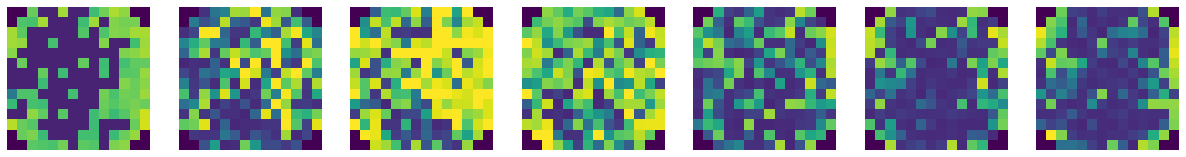

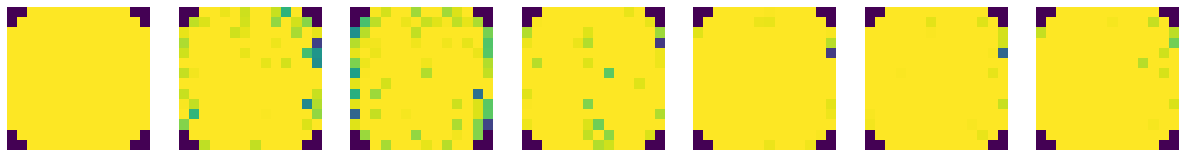

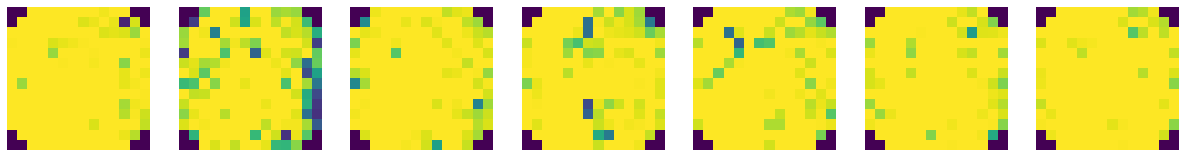

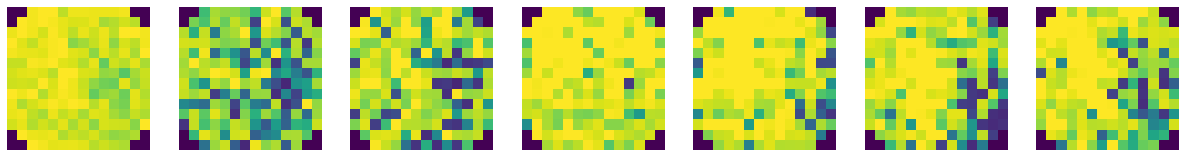

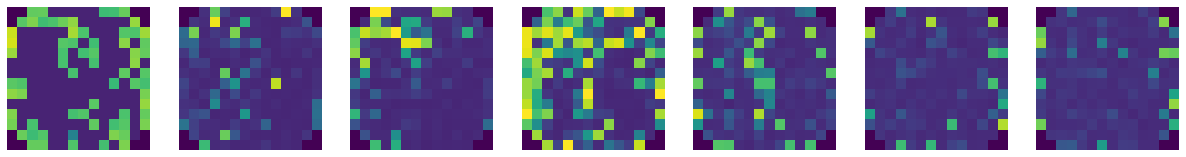

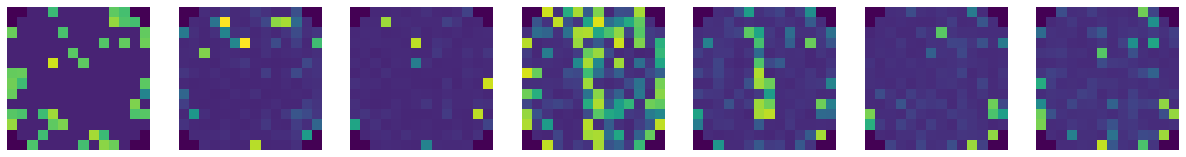

In [42]:
for well in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    plot_as_well(pred_val_dfs['Validation: 3R'], 
                 well,
                 use_cols=['label', 'D5_pred', 'D6_pred', 'D7_pred', 'D8_pred', 'D9_pred', 'D10_pred'])
    plt.savefig('figs/fig-1c-%s.pdf' % well, bbox_inches='tight')

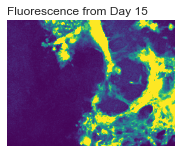

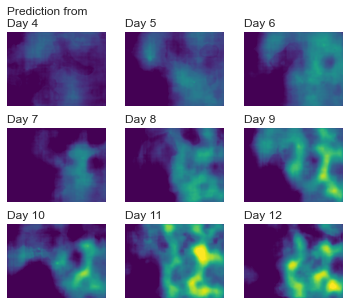

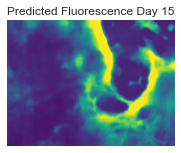

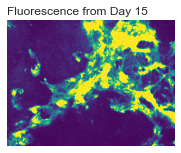

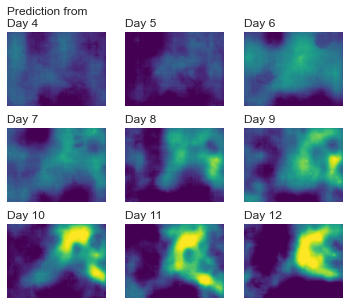

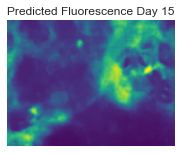

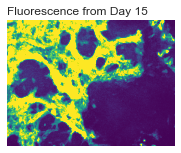

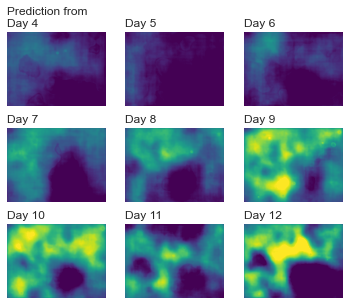

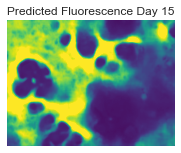

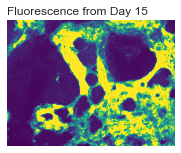

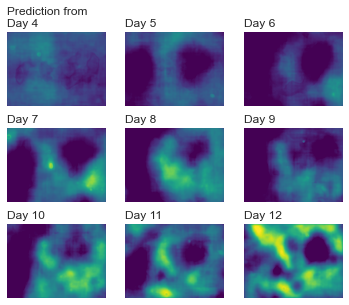

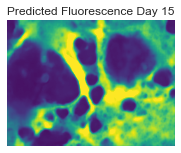

In [38]:
### Original validation set ###
# Gradual improvement of segmentation output

###
# import os
# import numpy as np
# import pandas as pd
# from collect_predictions import get_data_gen, CustomGenerator
# from data_loader import get_identifier

# root = "/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex15_full"
# valid_gen = get_data_gen(os.path.join(root, '0-to-0'), CustomGenerator, batch_size=8, with_label=True)
# identifier_mapping = {i: get_identifier(valid_gen.names[i]) for i in valid_gen.names}
# all_wells = set([idt[-2:] for idt in identifier_mapping.values()])

# seg_preds = [os.path.join(root, 'ex-valid-pred-to-15', f) \
#              for f in os.listdir(os.path.join(root, 'ex-valid-pred-to-15')) if f.startswith('seg')]

# sample_labels = {}
# for w in all_wells:
#     final_fl_id = [i for i in identifier_mapping if identifier_mapping[i][-2:] == w and identifier_mapping[i][2] == '15'][0]
#     if np.argmax(valid_gen.classify_y[final_fl_id]) == 3:
#         sample_labels[w] = valid_gen.load_ind(final_fl_id, force_augment_off=True)[1:3]

# score_df = pd.DataFrame(-np.ones((len(sample_labels), 9)), 
#                         columns=np.arange(4, 13), 
#                         index=['-'.join(w) for w in sample_labels.keys()])

# for f in seg_preds:
#     print(f)
#     seg_p = pickle.load(open(f, 'rb'))
#     for sp, n in zip(seg_p['seg_preds'], seg_p['pred_names']):
#         well = get_identifier(n)[-2:]
#         d = int(get_identifier(n)[2])
#         if '-'.join(well) in score_df.index:
#             sl = sample_labels[well]
#             w = sl[1][..., 0]
#             y = sl[0][..., 3] * 3 + sl[0][..., 2] * 2 + sl[0][..., 1]
#             score_df.loc['-'.join(well)][d] = pearsonr(y[np.nonzero(w)], sp[np.nonzero(w)])[0]


# s_mat = np.array(score_df)
# samples = np.where((s_mat[:, 1] > 0.2) * (s_mat[:, 4] > 0.3) * (s_mat[:, 5] > 0.4) * (s_mat[:, 6] > 0.4))[0]
# output = {}
# for s in samples:
#     w = tuple(score_df.index[s].split('-'))
#     output[w] = {}
#     final_fl_id = [i for i in identifier_mapping if identifier_mapping[i][-2:] == w and identifier_mapping[i][2] == '15'][0]
#     output[w]['label'] = valid_gen.load_ind(final_fl_id, force_augment_off=True)[1]

# for f in seg_preds:
#     print(f)
#     seg_p = pickle.load(open(f, 'rb'))
#     for sp, n in zip(seg_p['seg_preds'], seg_p['pred_names']):
#         well = get_identifier(n)[-2:]
#         d = int(get_identifier(n)[2])
#         if well in output:
#             output[well][d] = sp
###

output = pickle.load(open('VALIDATION/line1_3R/ex15_full/cla_seg-pred_samples.pkl', 'rb'))
sample_ws = [('A3', '136'), ('A3', '80'), ('A2', '24'), ('A2', '61')]

for sample_w in sample_ws:
    y = output[sample_w]['label']
    y = y[..., 3] * 3 + y[..., 2] * 2 + y[..., 1]

    plt.figure(figsize=(3, 2.5))
    plt.title('Fluorescence from Day 15', loc='left')
    plt.imshow(y, vmin=0., vmax=2.5, cmap='viridis')
    plt.axis('off')
    plt.savefig('figs/fig-1b-up-%s.pdf' % str(sample_w), bbox_inches='tight')

    plt.figure(figsize=(6, 5))
    for d in np.arange(4, 13):
        plt.subplot(3, 3, d-3)
        plt.imshow(output[sample_w][d], vmin=0.5, vmax=2.25, cmap='viridis')
        title = 'Day %d' % d if d > 4 else 'Prediction from\nDay %d' % d
        plt.title(title, ha='left', loc='left')
        plt.axis('off')
    plt.savefig('figs/fig-1b-down-%s.pdf' % str(sample_w), bbox_inches='tight')
    
    plt.figure(figsize=(3, 2.5))
    plt.title('Predicted Fluorescence Day 15', loc='left')
    plt.imshow(output[sample_w][15], vmin=0., vmax=2.25, cmap='viridis')
    plt.axis('off')
    plt.savefig('figs/fig-1b-down15-%s.pdf' % str(sample_w), bbox_inches='tight')
    

<br/><br/>
### Classification perf: prospective ###

N-samples: 96	Pos rate: 0.385	Prec: 0.711	Recall: 0.865	F1: 0.780	AUC: 0.902
N-samples: 96	Pos rate: 0.385	Prec: 0.966	Recall: 0.757	F1: 0.848	AUC: 0.986
N-samples: 96	Pos rate: 0.385	Prec: 0.968	Recall: 0.811	F1: 0.882	AUC: 0.985
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.351	F1: 0.520	AUC: 0.965
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.189	F1: 0.318	AUC: 0.939
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.081	F1: 0.150	AUC: 0.989
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.162	F1: 0.279	AUC: 0.975


<Figure size 432x288 with 0 Axes>

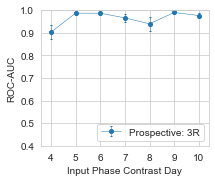

In [84]:
line_paths = {
    "Prospective: 3R": 'VALIDATION/line1_3R/prospective_ex0/'
}

pred_file_names = [
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

pred_cutoff = 2
### prepare labels ###
for line, line_path in line_paths.items():
    names = pickle.load(open(os.path.join(line_path, '0-to-0', 'names.pkl'), 'rb'))
    classify_labels = pickle.load(open(os.path.join(line_path, '0-to-0', 'classify_continuous_labels.pkl'), 'rb'))
    well_labels = {}
    for k in names:
        name = names[k]
        lab = classify_labels[k]
        well = get_identifier(name)[-2:]
        day = int(get_identifier(name)[2])
        if lab[1] > 0 and day >= 13:
            if not well in well_labels:
                well_labels[well] = {}
            well_labels[well][day] = lab[0][pred_cutoff:].sum()
    label_dict = {k: np.median(list(well_labels[k].values())) for k in well_labels}
    with open(os.path.join(line_path, 'cla_labels.pkl'), 'wb') as f:
        pickle.dump(label_dict, f)
###

roc_auc_curves = {}
pred_val_dfs = {}

for line, line_path in line_paths.items():
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name)) for pred_file_name in pred_file_names]
    label_dict = pickle.load(open(os.path.join(line_path, 'cla_labels.pkl'), 'rb'))
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                label_dict, 
                                                exclude_ambiguous=False, 
                                                pred_cutoff=pred_cutoff,
                                                label_cutoff=0.5,
                                                start=4,
                                                end=10)
    roc_auc_curves[line] = auc_curve
    pred_val_dfs[line] = pred_val_df

plt.clf()
plt.figure(figsize=(3, 2.5))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=4, linewidth=0.5, capsize=1.0)
plt.ylim(0.4, 1.0)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlim(3.6, 10.4)
plt.xticks([4, 5, 6, 7, 8, 9, 10])
plt.legend(loc='lower right')
plt.savefig('figs/fig-1h-auc_line.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

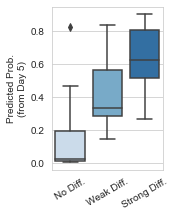

In [86]:
### Prediction box plot ###
names = pickle.load(open(os.path.join(line_path, '0-to-0', 'names.pkl'), 'rb'))
classify_labels = pickle.load(open(os.path.join(line_path, '0-to-0', 'classify_continuous_labels.pkl'), 'rb'))
well_labels = {}
for k in names:
    name = names[k]
    lab = classify_labels[k]
    well = get_identifier(name)[-2:]
    day = int(get_identifier(name)[2])
    if lab[1] > 0 and day >= 13:
        if not well in well_labels:
            well_labels[well] = {}
        well_labels[well][day] = lab[0]

label_dict = {k: np.argmax(np.stack(list(well_labels[k].values()), 0).mean(0)) for k in well_labels}
x = np.array([label_dict[k] for k in pred_val_df.index])
x[np.where(x == 2)] = 1
x[np.where(x == 3)] = 2
y = np.array(pred_val_df['D5_pred'])
plt.clf()
plt.figure(figsize=(2, 3))
sns.boxplot(x=x, y=y, palette='Blues')
plt.ylabel("Predicted Prob.\n(from Day 5)")
plt.xticks([0, 1, 2], ["No Diff.", "Weak Diff.", "Strong Diff."], rotation=30)
plt.savefig('figs/fig-1h-box.png', dpi=300, bbox_inches='tight')

<br/><br/>
### Classification perf: different well setting ###

N-samples: 924	Pos rate: 0.451	Prec: 0.696	Recall: 0.710	F1: 0.703	AUC: 0.804
N-samples: 924	Pos rate: 0.451	Prec: 0.684	Recall: 0.746	F1: 0.713	AUC: 0.822
N-samples: 924	Pos rate: 0.451	Prec: 0.685	Recall: 0.772	F1: 0.726	AUC: 0.851
N-samples: 924	Pos rate: 0.451	Prec: 0.828	Recall: 0.760	F1: 0.793	AUC: 0.913
N-samples: 924	Pos rate: 0.451	Prec: 0.985	Recall: 0.765	F1: 0.861	AUC: 0.954
N-samples: 504	Pos rate: 0.478	Prec: 0.569	Recall: 0.324	F1: 0.413	AUC: 0.503
N-samples: 504	Pos rate: 0.478	Prec: 0.768	Recall: 0.647	F1: 0.703	AUC: 0.815
N-samples: 504	Pos rate: 0.478	Prec: 0.861	Recall: 0.643	F1: 0.736	AUC: 0.851
N-samples: 504	Pos rate: 0.478	Prec: 0.886	Recall: 0.548	F1: 0.677	AUC: 0.839
N-samples: 256	Pos rate: 0.754	Prec: 0.699	Recall: 0.301	F1: 0.420	AUC: 0.430
N-samples: 256	Pos rate: 0.754	Prec: 0.925	Recall: 0.762	F1: 0.835	AUC: 0.845
N-samples: 256	Pos rate: 0.754	Prec: 0.912	Recall: 0.912	F1: 0.912	AUC: 0.899
N-samples: 256	Pos rate: 0.754	Prec: 0.938	Recall: 0.933	F1: 0.9

<Figure size 432x288 with 0 Axes>

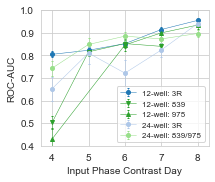

In [111]:
line_paths = {
    '12-well: 3R': 'VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    '12-well: 839': 'VALIDATION/different_wells/12well/line_839/ex0/',
    '12-well: 975': 'VALIDATION/different_wells/12well/line_975/ex0/',
    '24-well: 3R': 'VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
    '24-well: 839/975': 'VALIDATION/different_wells/24well/line_975-839/ex0/',
}

pred_file_names = [
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

label_cutoff = 0.5
pred_cutoff = 2
roc_auc_curves = {}
pred_val_dfs = {}

### prepare labels ###
# label_path = 'VALIDATION/different_wells/12well/raw_labels.csv'
# label_df = read_validation_additional_lines_labels(file_path=label_path)
# label_df.index = [(p[0], p[3]) for p in label_df.index]
# _3R_labels = generate_label_for_3R('VALIDATION/different_wells/12well/line1_3R/ex2-12well/names.pkl',
#                                    'VALIDATION/different_wells/12well/line1_3R/ex2-12well/classify_continuous_labels.pkl')
# label_df['3R'] = [_3R_labels[k] if k in _3R_labels else np.nan for k in label_df.index]
# label_df.to_csv('VALIDATION/different_wells/12well/labels.csv')

# label_path = 'VALIDATION/different_wells/24well/raw_labels.csv'
# label_df = read_validation_additional_lines_labels(file_path=label_path)
# label_df.index = [(p[0], p[3]) for p in label_df.index]
# _3R_labels = generate_label_for_3R('VALIDATION/different_wells/24well/line1_3R/ex0-24well/names.pkl',
#                                    'VALIDATION/different_wells/24well/line1_3R/ex0-24well/classify_continuous_labels.pkl')
# label_df['3R'] = [_3R_labels[k] if k in _3R_labels else np.nan for k in label_df.index]
# label_df.to_csv('VALIDATION/different_wells/24well/labels.csv')
###

label_df_12 = pd.read_csv('VALIDATION/different_wells/12well/labels.csv', index_col=0)
label_df_12.index = [eval(p) for p in label_df_12.index]
label_df_24 = pd.read_csv('VALIDATION/different_wells/24well/labels.csv', index_col=0)
label_df_24.index = [eval(p) for p in label_df_24.index]

for line, line_path in line_paths.items():
    line_name = get_identifier(line_path)[0].split('_')[1]
    if line.startswith('12'):
        label_dict = dict(zip(label_df_12.index, label_df_12[line_name]))
    elif line.startswith('24'):
        label_dict = dict(zip(label_df_24.index, label_df_24[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=(not '3R' in line), 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    
    roc_auc_curves[line] = auc_curve
    pred_val_dfs[line] = pred_val_df


plt.clf()
plt.figure(figsize=(3, 2.5))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=4, linewidth=0.5, capsize=1.0)
plt.ylim(0.4, 1.0)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlim(3.7, 8.3)
plt.legend(loc='lower right', prop={'size': 8})
plt.savefig('figs/fig-2b.png', dpi=300, bbox_inches='tight')

<br/><br/>
### Classification perf: different differentiation media / instrument setting ###

3R
N-samples: 920	Pos rate: 0.342	Prec: 0.700	Recall: 0.771	F1: 0.734	AUC: 0.895
N-samples: 920	Pos rate: 0.342	Prec: 0.592	Recall: 0.886	F1: 0.710	AUC: 0.874
N-samples: 920	Pos rate: 0.342	Prec: 0.761	Recall: 0.476	F1: 0.586	AUC: 0.805
N-samples: 920	Pos rate: 0.342	Prec: 0.788	Recall: 0.686	F1: 0.733	AUC: 0.895
N-samples: 920	Pos rate: 0.342	Prec: 0.706	Recall: 0.768	F1: 0.736	AUC: 0.901
839
N-samples: 362	Pos rate: 0.343	Prec: 0.363	Recall: 0.766	F1: 0.492	AUC: 0.497
N-samples: 362	Pos rate: 0.343	Prec: 0.547	Recall: 0.750	F1: 0.633	AUC: 0.777
N-samples: 362	Pos rate: 0.343	Prec: 0.839	Recall: 0.839	F1: 0.839	AUC: 0.959
N-samples: 362	Pos rate: 0.343	Prec: 0.949	Recall: 0.750	F1: 0.838	AUC: 0.972
N-samples: 362	Pos rate: 0.343	Prec: 0.936	Recall: 0.823	F1: 0.876	AUC: 0.971
3R
N-samples: 85	Pos rate: 0.647	Prec: 0.800	Recall: 0.436	F1: 0.565	AUC: 0.738
N-samples: 85	Pos rate: 0.647	Prec: 0.870	Recall: 0.727	F1: 0.792	AUC: 0.828
N-samples: 85	Pos rate: 0.647	Prec: 0.875	Recall: 0.764	

<Figure size 432x288 with 0 Axes>

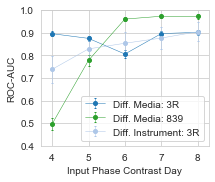

In [170]:
### Different differentiation protocol ###
line_paths = {
    'Diff. Media: 3R': 'VALIDATION/different_differentiation/line1_3R/ex0/',
    'Diff. Media: 839': 'VALIDATION/different_differentiation/line_839/ex0/',
    'Diff. Instrument: 3R': 'VALIDATION/line1_3R/ex2_other_instrument/',
}

pred_file_names = [
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

exclude_ambiguous = [False, True, False]

label_cutoff = 0.5
pred_cutoff = 2

### prepare labels ###
# label_path = 'VALIDATION/different_differentiation/raw_labels.csv'
# label_df = read_validation_additional_lines_labels(file_path=label_path)
# _3R_labels = generate_label_for_3R('VALIDATION/different_differentiation/line1_3R/ex0/names.pkl',
#                                    'VALIDATION/different_differentiation/line1_3R/ex0/classify_continuous_labels.pkl')
# label_df['3R'] = [_3R_labels[k] if k in _3R_labels else np.nan for k in label_df.index]
# label_df.to_csv('VALIDATION/different_differentiation/labels.csv')
###

label_path = 'VALIDATION/different_differentiation/labels.csv'
diff_media_label_df = pd.read_csv(label_path, index_col=0)
diff_media_label_df.index = [eval(p) for p in diff_media_label_df.index]

label_path = 'VALIDATION/line1_3R/ex2_other_instrument/other_instrument_labels.csv'
diff_ins_label_df = read_validation_additional_lines_labels(file_path=label_path)
diff_ins_label_df.columns = ['3R']
diff_ins_label_df.index = [(p[0], '5') for p in diff_ins_label_df.index]

roc_auc_curves = {}
pred_val_dfs = {}
for line, line_path in line_paths.items():
    line_name = get_identifier(line_path)[0].split('_')[1]
    print(line_name)
    label_df = diff_media_label_df if line.startswith('Diff. Media') else diff_ins_label_df
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=(not '3R' in line), 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    roc_auc_curves[line] = auc_curve
    pred_val_dfs[line] = pred_val_df

plt.clf()
plt.figure(figsize=(3, 2.5))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=4, linewidth=0.5, capsize=1.0)
plt.ylim(0.4, 1.0)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlim(3.7, 8.3)
plt.legend(loc='lower right')
plt.savefig('figs/fig-2d.png', dpi=300, bbox_inches='tight')

<br/><br/>
### Classification perf: 10 additional lines ###

In [213]:
line_paths = {
    'Test: 477': 'VALIDATION/line_477/ex0/',
    'Test: 202': 'VALIDATION/line_202/ex0/',
    'Test: 20': 'VALIDATION/line_20/ex0/',
    'Test: 100': 'VALIDATION/line_100/ex4/',
    'Test: 142': 'VALIDATION/line_142/ex1/',
    'Test: 273': 'VALIDATION/line_273/ex2/',
    'Test: 839': 'VALIDATION/line_839/ex1/',
    'Test: 480': 'VALIDATION/line_480/ex0/',
    'Test: 854': 'VALIDATION/line_854/ex1/',
    'Test: 975': 'VALIDATION/line_975/ex0/',
}

pred_file_names = [
    'ex-valid-pred-to-18',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

label_df = read_validation_additional_lines_labels('VALIDATION/additional_lines_labels.csv')
label_cutoff = 0.5
pred_cutoff = 2

roc_auc_curves = {}
pred_val_dfs = {}
for line, line_path in line_paths.items():
    line_name = get_identifier(line_path)[0].split('_')[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=(not '3R' in line),
                                                    start=4,
                                                    end=8,
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff)
    roc_auc_curves[line] = auc_curve
    pred_val_dfs[line] = pred_val_df


477
N-samples: 1081	Pos rate: 0.508	Prec: 0.528	Recall: 0.852	F1: 0.652	AUC: 0.649
N-samples: 1081	Pos rate: 0.508	Prec: 0.550	Recall: 0.807	F1: 0.654	AUC: 0.661
N-samples: 1081	Pos rate: 0.508	Prec: 0.828	Recall: 0.361	F1: 0.503	AUC: 0.777
N-samples: 1081	Pos rate: 0.508	Prec: 0.973	Recall: 0.732	F1: 0.836	AUC: 0.967
N-samples: 1081	Pos rate: 0.508	Prec: 0.989	Recall: 0.847	F1: 0.913	AUC: 0.980
202
N-samples: 856	Pos rate: 0.395	Prec: 0.422	Recall: 0.648	F1: 0.511	AUC: 0.522
N-samples: 856	Pos rate: 0.395	Prec: 0.441	Recall: 0.462	F1: 0.451	AUC: 0.635
N-samples: 856	Pos rate: 0.395	Prec: 0.597	Recall: 0.612	F1: 0.604	AUC: 0.745
N-samples: 856	Pos rate: 0.395	Prec: 0.972	Recall: 0.305	F1: 0.464	AUC: 0.929
N-samples: 856	Pos rate: 0.395	Prec: 0.976	Recall: 0.355	F1: 0.521	AUC: 0.955
20
N-samples: 1065	Pos rate: 0.932	Prec: 0.918	Recall: 0.753	F1: 0.827	AUC: 0.294
N-samples: 1065	Pos rate: 0.932	Prec: 0.943	Recall: 0.821	F1: 0.878	AUC: 0.710
N-samples: 1065	Pos rate: 0.932	Prec: 0.945	Re

In [216]:
### 24-well additional lines for seg (classification evaluation) ###
line_paths = {
    'Test: Combined': 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex1-day14/',
}

pred_file_names = [
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

label_cutoff = 0.5
pred_cutoff = 2
label_path = 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/day14_labels.pkl'
label_dict = pickle.load(open(label_path, 'rb'))
label_dict = {get_identifier(k)[-2:]: v[2:].sum() for k, v in label_dict.items()} # All positive
for k in pred_dicts[0].keys():
    if not k[-2:] in label_dict:
         label_dict[k[-2:]] = 0. # Everything without fluorescence should be negative

for line, line_path in line_paths.items():
    line_name = get_identifier(line_path)[0].split('_')[1]
    print(line_name)
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=False,
                                                    start=4,
                                                    end=8,
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff)
    roc_auc_curves[line] = auc_curve
    pred_val_dfs[line] = pred_val_df


additional-combined-24
N-samples: 540	Pos rate: 0.500	Prec: 0.750	Recall: 0.900	F1: 0.818	AUC: 0.845
N-samples: 540	Pos rate: 0.500	Prec: 0.760	Recall: 0.893	F1: 0.821	AUC: 0.843
N-samples: 540	Pos rate: 0.500	Prec: 0.764	Recall: 0.937	F1: 0.842	AUC: 0.845
N-samples: 540	Pos rate: 0.500	Prec: 0.762	Recall: 0.915	F1: 0.832	AUC: 0.854


<Figure size 432x288 with 0 Axes>

<Figure size 216x180 with 0 Axes>

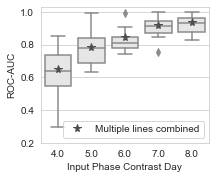

In [225]:
combined_curve, combined_df = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5, start=4, end=8)

plt.clf()
plt.figure(figsize=(3, 2.5))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=4, linewidth=0.5, capsize=1.0)
plt.ylim(0.4, 1.0)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlim(3.7, 8.3)
plt.legend(loc='lower left', bbox_to_anchor=(1.1, -0.05), prop={'size': 8.3})
plt.savefig('figs/fig-2h-1.png', dpi=300, bbox_inches='tight')

plt.clf()
plt.figure(figsize=(3, 2.5))
plot_roc_auc_box(roc_auc_curves, start=4, end=8)
plt.plot(np.arange(len(sorted(combined_curve.keys()))), 
         [combined_curve[k] for k in sorted(combined_curve.keys())], 
         '*', color=(0.3, 0.3, 0.3, 1.0), markersize=8, linewidth=1.6, label='Multiple lines combined', zorder=3)
plt.legend()
plt.ylim(0.2, 1.03)
plt.savefig('figs/fig-2h-2.png', dpi=300, bbox_inches='tight')

<br/><br/><br/><br/>
## Generate Segmentation Output (Run on sherlock) ##

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import pickle
import numpy as np
import pandas as pd
import scipy
import cv2
import tifffile
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score

from data_loader import get_identifier, get_ex_day
from models import Segment, ClassifyOnSegment
from layers import load_partial_weights, fill_first_layer, evaluate_confusion_mat, summarize_conf_mat
from data_generator import CustomGenerator, PairGenerator, enhance_weight_for_false_positives


def get_day(n):
    return int(get_identifier(n)[2])


def get_ind(name, valid_ids):
    _id = get_identifier(name)
    if 'Z' in _id[-1]:
        _id = _id[:4] + tuple([_id[4].split('Z')[0]])
    for k in valid_ids:
        if _id[-3:] == valid_ids[k][-3:]:
            return k
    return None


def get_validation_data_gen(data_root):
    name_file = os.path.join(data_root, "names.pkl")
    X_ct = len([f for f in os.listdir(data_root) if f.startswith('X_')])
    X_files = [os.path.join(data_root, "X_%d.pkl" % i) for i in range(X_ct)]

    segment_y_files = [os.path.join(data_root, "segment_continuous_y_%d.pkl" % i) for i in range(X_ct)]
    segment_w_files = [os.path.join(data_root, "segment_continuous_w_%d.pkl" % i) for i in range(X_ct)]
    classify_label_file = os.path.join(data_root, "classify_continuous_labels.pkl")
    valid_gen = CustomGenerator(
        name_file,
        X_files, 
        segment_y_files=segment_y_files, 
        segment_w_files=segment_w_files,
        n_segment_classes=4,
        segment_class_weights=[1, 1, 1, 1],
        segment_label_type='continuous',
        classify_label_file=classify_label_file,
        n_classify_classes=4,
        classify_class_weights=[1, 1, 1, 1],
        classify_label_type='continuous')
    return valid_gen


def load_cla_preds(pred_paths):
    cla_dict = {}
    for pred_path in pred_paths:
        cla_result = pickle.load(open(os.path.join(pred_path, 'cla.pkl'), 'rb'))
        for name, pred in zip(cla_result['pred_names'], cla_result['cla_preds']):
            if not name in cla_dict:
                cla_dict[name] = []
            cla_dict[name].append(pred)
    
    cla_dict = {k: np.stack(v, 0).mean(0) for k, v in cla_dict.items()}
    return cla_dict


def collect_segmentation_performance(pred_paths, valid_gen, median_blur=False, skip_unlabeled=True):
    if isinstance(pred_paths, str):
        pred_paths = [pred_paths]
    fs = [[f for f in os.listdir(pred_path) if f.startswith('seg_') and f.endswith('.pkl')] for pred_path in pred_paths]
    assert all([set(fs[0]) == set(_fs) for _fs in fs])
        
    random_pixel_seg_preds = []
    random_pixel_seg_trues = []
    random_pixel_days = []
    random_pixel_ids = []

    sample_pearsonrs = []
    sample_days = []
    sample_ids = []
    
    day14_samples = []
    
    valid_ids = {k: get_identifier(v) for k, v in valid_gen.names.items()}
    cla_dict = load_cla_preds(pred_paths)
    for f in sorted(fs[0], key=lambda x: int(x.split('_')[1].split('.')[0])):
    
        seg_preds = []
        pred_names = []
        for pred_path in pred_paths:
            dat = pickle.load(open(os.path.join(pred_path, f), 'rb'))
            seg_preds.append(dat['seg_preds'])
            pred_names.append(dat['pred_names'])
        
        assert all([set(pred_names[0]) == set(p_n) for p_n in pred_names])
            
        for i, name in enumerate(pred_names[0]):

            s_pred = [s_preds[i] for s_preds in seg_preds]
            s_pred = np.stack(s_pred, 0).mean(0)
            
            name = name[0] if isinstance(name, tuple) else name
            sample_id = get_identifier(name)
            day = get_day(name)
            ind = get_ind(name, valid_ids)
            if ind is None:
                print("Cannot find %s" % str(sample_id))
                continue

            X, y, w, _ = valid_gen.load_ind(ind)
            if y is None or w is None:
                if skip_unlabeled:
                    continue
                y = np.zeros((X.shape[0], X.shape[1], 4))
                w = np.ones_like(X)
            s_true = y[..., 1] + y[..., 2] * 2 + y[..., 3] * 3
            if median_blur:
                s_true = cv2.medianBlur((s_true/3*255).astype(int).astype('uint8'), 13).astype(float) / 255 * 3
            
            s_w = w[..., 0]
            if s_w.sum() == 0:
                continue
            
            if day == 14:
                day14_samples.append((X, y, w, s_pred, name))

            _s_pred = s_pred[s_w == 1]
            _s_true = s_true[s_w == 1]
            pr = pearsonr(_s_pred, _s_true)[0]
            sample_pearsonrs.append(pr)
            sample_days.append(day)
            sample_ids.append(sample_id)

            rs_inds = np.random.choice(np.arange(_s_pred.shape[0]), (5000,), replace=False)
            if np.argmax(cla_dict[name]) == 0 and cla_dict[name][0] > 0.6: 
                # Strong classification signal as no differentiation
                _s_pred = np.zeros_like(_s_pred)
            random_pixel_seg_preds.append(_s_pred[rs_inds])
            random_pixel_seg_trues.append(_s_true[rs_inds])
            random_pixel_days.extend([day] * len(rs_inds))
            random_pixel_ids.extend([sample_id] * len(rs_inds))

    sample_score_df = pd.DataFrame({'pearson-r': sample_pearsonrs, 'day': sample_days}, index=sample_ids)
    random_pixel_df = pd.DataFrame({'pred': np.concatenate(random_pixel_seg_preds), 
                                    'true': np.concatenate(random_pixel_seg_trues), 
                                    'day': random_pixel_days,
                                    'id': random_pixel_ids})
    
    print("LABEL AVG: %.3f" % random_pixel_df['true'].mean())
    print("PRED AVG: %.3f" % random_pixel_df['pred'].mean())
    print("SAMPLE PR MEDIAN: %.3f" % np.nanmedian(sample_score_df['pearson-r']))
    print("SAMPLE (D>=12) PR MEDIAN: %.3f" % np.nanmedian(sample_score_df[sample_score_df['day'] >= 12]['pearson-r']))
    print("ALL PIXEL PR: %.3f" % pearsonr(random_pixel_df['true'], random_pixel_df['pred'])[0])
    print("ALL PIXEL (D>=12) PR: %.3f" % pearsonr(random_pixel_df[random_pixel_df['day'] >= 12]['true'], random_pixel_df[random_pixel_df['day'] >= 12]['pred'])[0])
    
    return sample_score_df, random_pixel_df, day14_samples


def pick_seg_pred_samples(valid_gen, day14_samples, seed=123):
    np.random.seed(seed)
    class_ct = {i: 0 for i in range(4)}

    write_samples = []
    day14_samples = sorted(day14_samples, key=lambda x: x[-1])
    np.random.shuffle(day14_samples)
    for s in day14_samples:
        X, y, w, s_pred, name = s
        j = [i for i, n in valid_gen.names.items() if n == name][0]
        cla_class = np.argmax(valid_gen.classify_y[j])
        if class_ct[cla_class] > 20:
            continue
        write_samples.append((X, y, w, s_pred, name))
        class_ct[cla_class] += 1
    return write_samples

In [277]:
### Original valid and test sets ###
ROOT = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/'
line_paths = {
    'Validation: 3R': ROOT + 'VALIDATION/line1_3R/ex15_full/',
    'Test: TNNI': ROOT + 'VALIDATION/line3_TNNI/ex4_full/',
    '12-well: 3R': ROOT + 'VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    '24-well: 3R': ROOT + 'VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
    'Diff. Media: 3R': ROOT + 'VALIDATION/different_differentiation/line1_3R/ex0/',
}

pred_file_names = ['ex-valid-pred-to-0',]

for line, line_path in line_paths.items():
    pred_paths = [os.path.join(line_path, pred_file_name) for pred_file_name in pred_file_names]
    valid_gen = get_validation_data_gen(os.path.join(line_path, '0-to-0'))
    sample_score_df, random_pixel_df, day14_samples = collect_segmentation_performance(pred_paths, valid_gen, median_blur=False)
    with open(os.path.join(line_path, 'seg_summary.pkl'), 'wb') as f:
        pickle.dump([sample_score_df, random_pixel_df], f)
    with open(os.path.join(line_path, 'seg_samples.pkl'), 'wb') as f:
        pickle.dump(pick_seg_pred_samples(valid_gen, day14_samples, seed=123), f)
    if line == 'Test: TNNI':
        with open(os.path.join(line_path, 'seg_all.pkl'), 'wb') as f:
            pickle.dump(day14_samples, f)


<br/><br/><br/><br/>
## Segmentation perf: original validation/test ##

In [177]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def get_pixel_level_correlation(pixel_df):
    curve = {}
    for d in sorted(set(pixel_df['day'])):
        sub_df = pixel_df[pixel_df['day'] == d]
        score = pearsonr(sub_df['true'], sub_df['pred'])[0]
        sd = []
        for _ in range(10):
            bs_inds = np.random.choice(np.arange(len(sub_df)), (int(0.1*len(sub_df)),), replace=False)
            sd.append(pearsonr(sub_df.iloc[bs_inds]['true'], sub_df.iloc[bs_inds]['pred'])[0])
        sd = np.std(sd)
        curve[d] = (score, sd)
    return curve



def boxplot_seg_pearsonr_distri(prs, 
                                properties,
                                boxplot_fig_output='seg_pearsonr_distri.png',
                                samplect_fig_output='seg_sample_count.png'):

    x_axis = sorted(set(properties))

    prs_by_x = {_x: [] for _x in x_axis}
    for pr, prop in zip(prs, properties):
        if pr == pr:
            prs_by_x[prop].append(pr)

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=2)
    data = [prs_by_x[_x] for _x in x_axis]
    bplot = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis)),
        flierprops=red_diamond,
        widths=0.2,
        manage_ticks=False)
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim(-0.41, 1.01)
    if not boxplot_fig_output is None:
        plt.savefig(boxplot_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 1.5))
    ax.plot(np.arange(len(x_axis)), [len(prs_by_x[_x]) for _x in x_axis], c='pink')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([0, ax.get_ylim()[1]])
    if not samplect_fig_output is None:
        plt.savefig(samplect_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()

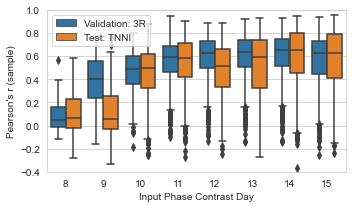

In [181]:
ROOT = './'
line_paths = {
    'Validation: 3R': ROOT + 'VALIDATION/line1_3R/ex15_full/',
    'Test: TNNI': ROOT + 'VALIDATION/line3_TNNI/ex4_full/',
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)


plt.figure(figsize=(5, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
legend = plt.gca().legend(loc='upper left')
plt.ylim(-0.4, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
plt.savefig('figs/fig-1f-box.png', bbox_inches='tight', dpi=300)

# plt.figure(figsize=(5, 3))
# for k, curve in seg_score_by_pixel.items():
#     x = sorted(curve.keys())
#     y = [curve[_x][0] for _x in x]
#     yerr = [curve[_x][1] for _x in x]
#     plt.errorbar(x, y, yerr=yerr, capsize=4, marker='.', markersize=5, linewidth=0.5, label=k)
# plt.legend()
# plt.xlabel('Input Phase Contrast Day')
# plt.ylabel('Pearson\'s r (pixel)')
# plt.savefig('figs/fig-1f-line.png', dpi=300)

## Segmentation perf: original test samples ##

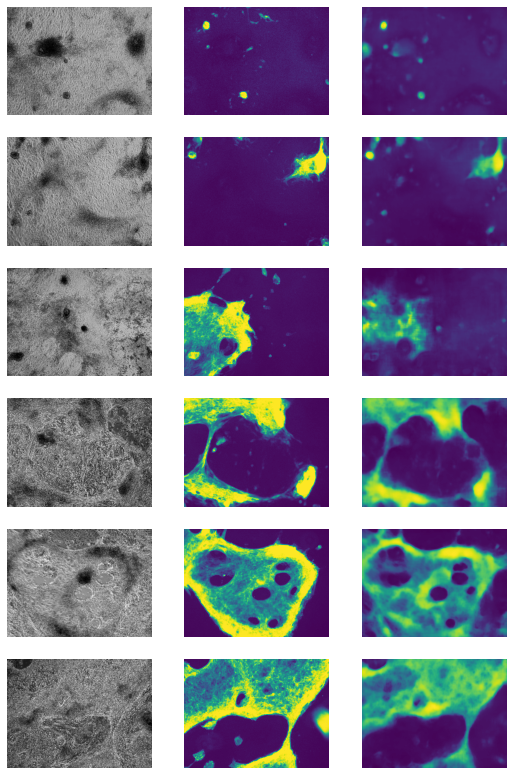

In [10]:
seg_samples = pickle.load(open('VALIDATION/line3_TNNI/ex4_full/seg_samples.pkl', 'rb'))
plot_samples = [
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B2_05_1_98_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B2_05_1_41_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B1_04_1_126_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/A3_03_1_73_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B1_04_1_187_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B1_04_1_118_Phase Contrast_001.tif',
]

plt.figure(figsize=(9, 14))

seg_names = [s[-1] for s in seg_samples]
for i, n in enumerate(plot_samples):
    s = seg_samples[seg_names.index(n)]
    X = s[0][..., 0]
    y = s[1][..., 3]*3 + s[1][..., 2]*2 + s[1][..., 1]
    
    plt.subplot(6, 3, 3*i+1)
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.subplot(6, 3, 3*i+2)
    plt.imshow(y, cmap='viridis')
    plt.axis('off')
    plt.subplot(6, 3, 3*i+3)
    plt.imshow(s[3], cmap='viridis')
    plt.axis('off')
plt.savefig('figs/fig-1g-raw.png', dpi=300)

<br/><br/>
## Segmentation perf: different well setting ##

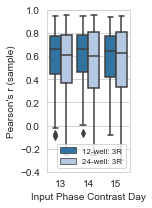

In [184]:
ROOT = './'
line_paths = {
    '12-well: 3R': ROOT + 'VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    '24-well: 3R': ROOT + 'VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1 = seg_score1[seg_score1['day'] >= 13]
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)

plt.figure(figsize=(2, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
legend = plt.gca().legend(loc='lower right', prop={'size': 8})
plt.ylim(-0.4, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
plt.savefig('figs/fig-2c.png', bbox_inches='tight', dpi=300)

## Segmentation perf: different differentiation media setting ##

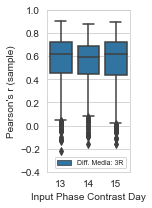

In [188]:
ROOT = './'
line_paths = {
    'Diff. Media: 3R': ROOT + 'VALIDATION/different_differentiation/line1_3R/ex0/',
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1 = seg_score1[seg_score1['day'] >= 13]
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)

plt.figure(figsize=(2, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
legend = plt.gca().legend(loc='lower right', prop={'size': 7})
plt.ylim(-0.4, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
plt.savefig('figs/fig-2e.png', bbox_inches='tight', dpi=300)

<br/><br/><br/><br/>
## Generate Segmentation Output for additional lines (Run on sherlock) ##

In [ ]:
import os
import numpy as np
import scipy
import pickle
from collect_predictions import get_model, get_data_gen
from data_generator import CustomGenerator

def collect_preds(valid_gen, 
                  model, 
                  pred_save_dir, 
                  input_transform=None, 
                  input_filter=None,
                  target_day=18):
    
    os.makedirs(pred_save_dir, exist_ok=True)

    pred_save = {"seg_preds": [], "seg_trues": [], "seg_ws": [], "pred_names": []}
    file_ct = 0
    cla_preds = []
    cla_trues = []
    cla_ws = []
    pred_names = []

    for batch in valid_gen:
        X = batch[0]
        names = batch[-1]
        if not input_filter is None:
            inds = input_filter(batch)
        else:
            inds = np.arange(X.shape[0])
        if len(inds) == 0:
            continue
        if not input_transform is None:
            X = input_transform(X)
        
        ###   
        X[..., 1] = target_day
        ###
        
        pred = model.model.predict(X)
        seg_pred = scipy.special.softmax(pred[0], -1)
        seg_pred = seg_pred[..., 1] + seg_pred[..., 2]*2 + seg_pred[..., 3] * 3
        pred_save["seg_preds"].extend([seg_pred[i] for i in inds])

        cla_pred = scipy.special.softmax(pred[1], -1)
        cla_preds.extend([cla_pred[i] for i in inds])

        pred_save["pred_names"].extend([names[i] for i in inds])
        pred_names.extend([names[i] for i in inds])

        if not batch[1] is None:
            seg_true, cla_true = batch[1]
            seg_y = seg_true[..., 1] + seg_true[..., 2]*2 + seg_true[..., 3] * 3
            seg_w = seg_true[..., -1]
            cla_y, cla_w = cla_true[..., :-1], cla_true[..., -1]
            pred_save["seg_trues"].extend([seg_y[i] for i in inds])
            pred_save["seg_ws"].extend([seg_w[i] for i in inds])
        
            cla_trues.extend([cla_y[i] for i in inds])
            cla_ws.extend([cla_w[i] for i in inds])

        if len(pred_save["seg_preds"]) >= 500:
            with open(os.path.join(pred_save_dir, "seg_%d.pkl" % file_ct), 'wb') as f:
                pickle.dump(pred_save, f)
            pred_save = {"seg_preds": [], "seg_trues": [], "seg_ws": [], "pred_names": []}
            file_ct += 1

    with open(os.path.join(pred_save_dir, "seg_%d.pkl" % file_ct), 'wb') as f:
        pickle.dump(pred_save, f)
        
    with open(os.path.join(pred_save_dir, "cla.pkl"), 'wb') as f:
        pickle.dump({"cla_preds": np.stack(cla_preds, 0),
                     "cla_trues": np.stack(cla_trues, 0) if len(cla_trues) > 0 else cla_trues,
                     "cla_ws": np.stack(cla_ws, 0) if len(cla_ws) > 0 else cla_ws,
                     "pred_names": pred_names}, f)

In [ ]:
### Generate prediction for additional lines in 24 well ###
ROOT = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/'
line_path = ROOT + 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/'
valid_gen = get_data_gen(os.path.join(line_path, '0-to-0'), CustomGenerator, batch_size=8, with_label=False)

target_day = 20
for m, model_path in {'valid': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/model_save/ex_split/0-to-0_ex/bkp.model',
                      'test': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/model_save/ex_split/0-to-0_ex/test-bkp.model'}.items():
    model = get_model(model_path)
    collect_preds(valid_gen, 
                  model, 
                  os.path.join(line_path, 'ex-%s-pred-to-0_as-D%d' % (m, target_day)), 
                  input_transform=None, 
                  input_filter=None,
                  target_day=target_day)

### Collect prediction for additional lines in 24 well ###
pred_file_names = ['ex-valid-pred-to-0_as-D20', 'ex-test-pred-to-0_as-D20']
pred_paths = [os.path.join(line_path, pred_file_name) for pred_file_name in pred_file_names]
valid_gen = get_validation_data_gen(os.path.join(line_path, '0-to-0'))
sample_score_df, random_pixel_df, _ = \
    collect_segmentation_performance(pred_paths, valid_gen, median_blur=True, skip_unlabeled=False)
_, _, day14_samples = \
    collect_segmentation_performance(pred_paths, valid_gen, median_blur=False, skip_unlabeled=True)

# Exclude Day12-B1, Day12-D4, Day14-B1 due to blurry input / artifact
excluded = [('12', 'B1'), ('12', 'D4'), ('14', 'B1')]
sample_score_df = sample_score_df.loc[[w for w in sample_score_df.index if not tuple(w[2:4]) in excluded]]
random_pixel_df_valid_inds = [i for i, _id in zip(random_pixel_df.index, random_pixel_df['id']) if not _id[2:4] in excluded]
random_pixel_df = random_pixel_df.loc[random_pixel_df_valid_inds]
day14_samples = [s for s in day14_samples if not get_identifier(s[-1])[2:4] in excluded]

with open(os.path.join(line_path, 'seg_summary.pkl'), 'wb') as f:
    pickle.dump([sample_score_df, random_pixel_df], f)
with open(os.path.join(line_path, 'seg_samples.pkl'), 'wb') as f:
    pickle.dump(pick_seg_pred_samples(valid_gen, day14_samples, seed=123), f)
with open(os.path.join(line_path, 'seg_full.pkl'), 'wb') as f:
    pickle.dump(day14_samples, f)

<br/><br/><br/><br/>
## Segmentation perf: addtional lines ##

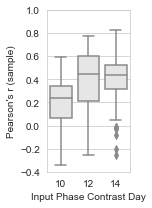

In [204]:
ROOT = './'
line_paths = {
    'Test: Combined': ROOT + 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/'
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1 = seg_score1[seg_score1['day'] >= 10]
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)

plt.figure(figsize=(2, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
_ = plt.gca().legend(loc='lower right').remove()
plt.ylim(-0.4, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
plt.savefig('figs/fig-2i-box.png', bbox_inches='tight', dpi=300)

## Segmentation perf: addtional lines example ##

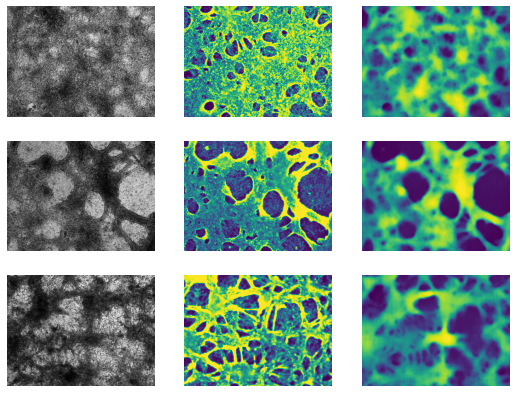

In [11]:
seg_samples = pickle.load(open('VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/seg_samples.pkl', 'rb'))

plot_samples = [
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/additional_lines_for_seg/line_additional-combined-24/ex0-pre/220130_213610_az24well_multiline_segmentation_D14_phase/220130_213610_Plate 1/A1_02_1_7_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/additional_lines_for_seg/line_additional-combined-24/ex0-pre/220130_213610_az24well_multiline_segmentation_D14_phase/220130_213610_Plate 1/A1_02_1_34_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/additional_lines_for_seg/line_additional-combined-24/ex0-pre/220130_213610_az24well_multiline_segmentation_D14_phase/220130_213610_Plate 1/D5_21_1_17_Phase Contrast_001.tif',
]
plt.figure(figsize=(9, 7))
seg_names = [s[-1] for s in seg_samples]
for i, n in enumerate(plot_samples):
    s = seg_samples[seg_names.index(n)]
    X = s[0][..., 0]
    y = s[1][..., 3]*3 + s[1][..., 2]*2 + s[1][..., 1]
    
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(y, cmap='viridis')
    plt.axis('off')
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(s[3], cmap='viridis')
    plt.axis('off')
plt.savefig('figs/fig-2i-raw.png', bbox_inches='tight', dpi=300)

<br/><br/><br/><br/>
## Segmentation perf: addtional lines example-by-score ##

0.014834951056224689
0.11808002594050268
0.2555035898038731
0.3998232188509129
0.5100216612692619
0.6558270304541229


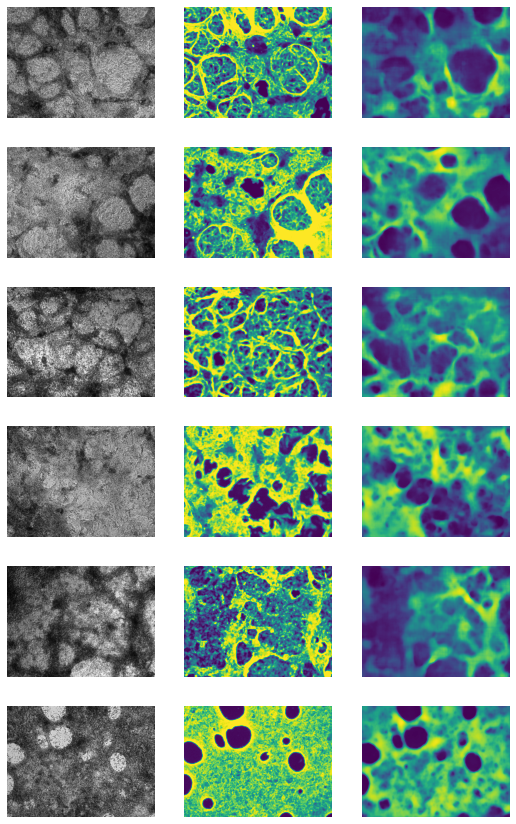

In [90]:
seg_full = pickle.load(open('VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/seg_full.pkl', 'rb'))
seg_score = pickle.load(open('VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/seg_summary2.pkl', 'rb'))[0]

plot_samples = [
    ('line_additional-combined-24', 'ex0-pre', '14', 'B5', '28'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'B5', '15'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'D5', '5'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'B5', '20'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'D2', '7'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'C1', '17'),
]

plt.figure(figsize=(9, 15))
n_rows = len(plot_samples)

for i, s in enumerate(plot_samples):
    pr = seg_score.loc[[s]]['pearson-r'][0]
    print(pr)
    p = [p for p in seg_full if get_identifier(p[-1]) == s][0]
    
    X = p[0][..., 0]
    y = p[1][..., 3]*3 + p[1][..., 2]*2 + p[1][..., 1]
    
    plt.subplot(n_rows, 3, i*3+1)
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.subplot(n_rows, 3, i*3+2)
    plt.imshow(y, cmap='viridis')
    plt.axis('off')
    plt.subplot(n_rows, 3, i*3+3)
    plt.imshow(p[3], cmap='viridis')
    plt.axis('off')
    
plt.savefig('figs/supp-fig-2b-add.png', bbox_inches='tight', dpi=300)